# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# magic word for producing visualizations in notebook
%matplotlib inline
from matplotlib import pyplot


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Wrangling

In [18]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [6]:
# Check string data types 
customers.loc[:, customers.dtypes == object]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
5,5D,5,34,D19_BUCH_CD,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
6,3B,3,23,D19_DROGERIEARTIKEL,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
7,1D,1,15,D19_SONSTIGE,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER
8,9E,9,55,D19_SONSTIGE,2004-10-14 00:00:00,W,COSMETIC,MULTI_BUYER
9,1D,1,15,D19_BUCH_CD,1997-07-14 00:00:00,W,COSMETIC,MULTI_BUYER


In [9]:
# Check mixed data types
customers['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [19]:
# Fix mixed data types
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace(['X'],'-1')

In [20]:
# Change datat type
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(float)

In [21]:
# Check mixed data types
customers['CAMEO_INTL_2015'].value_counts()

14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

In [22]:
# Fix mixed data types
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace(['XX'],'-1')

In [23]:
# Change datat types
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype(float)

In [24]:
# Check if there are any missing values
customers.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                  191416
ALTER_KIND3                  190377
ALTER_KIND2                  186552
ALTER_KIND1                  179886
KK_KUNDENTYP                 111937
EXTSEL992                     85283
KBA05_SEG7                    55980
KBA05_KW1                     55980
KBA05_SEG4                    55980
KBA05_SEG5                    55980
KBA05_SEG6                    55980
KBA05_MAXAH                   55980
KBA05_SEG8                    55980
KBA05_KW2                     55980
KBA05_VORB0                   55980
KBA05_KRSZUL                  55980
KBA05_VORB1                   55980
KBA05_KRSVAN                  55980
KBA05_KRSOBER                 55980
KBA05_SEG9                    55980
MOBI_REGIO                    55980
KBA05_KW3                     55980
KBA05_SEG3                    55980
KBA05_KRSHERST3               55980
KBA05_MAXBJ                   55980
KBA05_MAXHERST                55980
KBA05_MAXSEG                  55980
KBA05_MAXVORB               

In [25]:
# Check if there are any missing values
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

In [26]:
# drop columns that only appears in customer dataset
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1, inplace=True)

In [27]:
# drop columns with more thna 50% nan
customers.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','KK_KUNDENTYP','EXTSEL992'], axis=1, inplace=True)

In [28]:
# drop columns not needed for features
customers.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ'], axis=1, inplace=True)

In [29]:
# drop null values before scaling
customers.dropna(inplace=True)

In [21]:
# Save clean dataframe
customers.to_csv('customers_clean.csv', index=False)

In [30]:
def clean_data(df):
    """Function to clean the data set.

    Args:
        df: dataframe to be cleaned

    Returns:
        df: clean dataframe

    """

    # read dataframe
    df = df

    # Replace wrong data type
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace(['X'],'-1')
    
    # Change data typr from string to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(['XX'],'-1')
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    # drop columns with more thna 50% nan
    df.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','KK_KUNDENTYP','EXTSEL992'], axis=1, inplace=True)

    # drop columns not needed for features
    df.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ'], axis=1, inplace=True)

    # drop null values before scaling
    df.dropna(inplace=True)

     

    # save clean dataframe
    return df

In [31]:
clean_data(azdias)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
4,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
7,-1,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,0.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
9,-1,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3
10,0,1.0,10.0,10.0,6.0,0.0,0.0,1.0,6.0,0.0,...,4.0,8.0,11.0,10.0,6.0,9.0,5.0,3,2,3
27,-1,6.0,16.0,16.0,6.0,0.0,1.0,2.0,4.0,0.0,...,3.0,4.0,7.0,5.0,1.0,3.0,3.0,4,1,3
29,2,1.0,11.0,11.0,1.0,0.0,0.0,1.0,2.0,0.0,...,0.0,9.0,12.0,9.0,6.0,8.0,3.0,1,2,4
32,-1,4.0,19.0,18.0,1.0,0.0,0.0,2.0,2.0,0.0,...,3.0,1.0,1.0,1.0,6.0,9.0,7.0,1,1,1
33,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,4.0,0.0,...,1.0,6.0,8.0,5.0,4.0,9.0,1.0,3,2,2


In [28]:
# Save clean dataframe
azdias.to_csv('azdias_clean.csv', index=False)

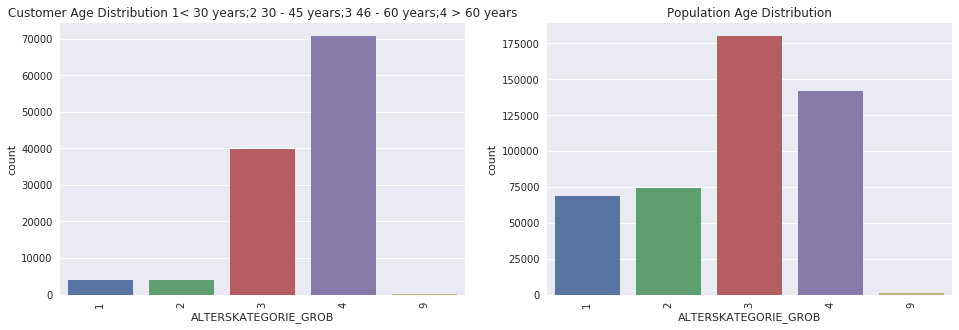

In [48]:
plt.figure(figsize = [16, 5])
base_color = sns.color_palette()[0]

plt.subplot(1, 2, 1)
ax1 = sns.countplot(data = customers, x = 'ALTERSKATEGORIE_GROB')
plt.xticks(rotation=90)
plt.title('Customer Age Distribution 1< 30 years;2 30 - 45 years;3 46 - 60 years;4 > 60 years');

plt.subplot(1, 2, 2)
sns.countplot(data =  azdias, x = 'ALTERSKATEGORIE_GROB')
plt.xticks(rotation=90)
plt.title('Population Age Distribution');

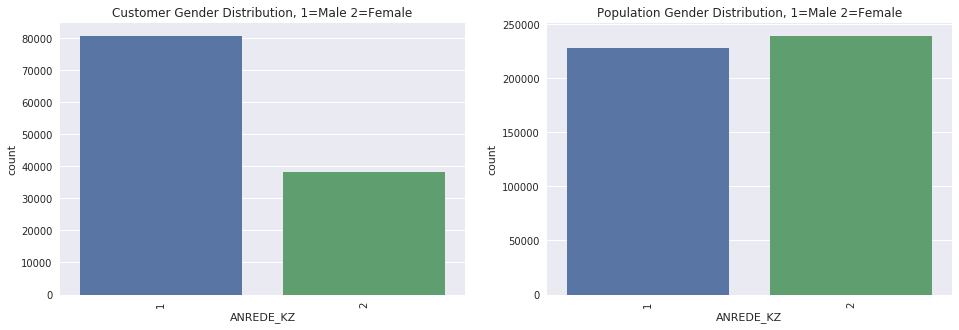

In [47]:
plt.figure(figsize = [16, 5])
base_color = sns.color_palette()[0]

plt.subplot(1, 2, 1)
ax1 = sns.countplot(data = customers, x = 'ANREDE_KZ')
plt.xticks(rotation=90)
plt.title('Customer Gender Distribution, 1=Male 2=Female');

plt.subplot(1, 2, 2)
sns.countplot(data =  azdias, x = 'ANREDE_KZ')
plt.xticks(rotation=90)
plt.title('Population Gender Distribution, 1=Male 2=Female');

###  Data wrangling Summary

I assessed the data for quality and tidiness issues.
The following issues were identified and corrected:

1. Mixed data types in column 18 and 19 changed to float
2. dropped columns that only appears in customer dataset
3. dropped columns with more thna 50% of values missing
4. dropped columns not needed for features
5. dropped null values to avoid errors when scaling


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Customers data set

In [2]:
customers_clean = pd.read_csv('customers_clean.csv')

In [3]:
# Preprocessing using standard scaler
scaler = StandardScaler()

In [4]:
scaled_features = scaler.fit_transform(customers_clean)

In [ ]:
# Use elbow method to find the correct value for k
sse = []
krange = range(1,10)
for k in krange:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

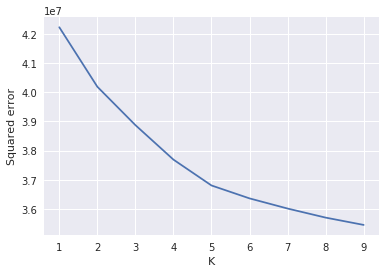

In [6]:
# Elbow plot
plt.xlabel('K')
plt.ylabel('Squared error')
plt.plot(krange,sse);

In [5]:
# instantitate kmeans
customers_km = KMeans(n_clusters=6)

In [6]:
# fit alogorith to features
cust_pred =  customers_km.fit_predict(scaled_features)

In [7]:
cust_pred

array([0, 1, 4, ..., 0, 1, 2], dtype=int32)

In [8]:
customers_clean['cluster'] = cust_pred

In [11]:
# Calculate Proportion of features which belong to different clusters
cust_proportions = customers_clean['cluster'].value_counts()/customers_clean.shape[0]

In [13]:
cust_proportions

4    0.297139
3    0.223687
0    0.196157
1    0.177411
5    0.100823
2    0.004783
Name: cluster, dtype: float64

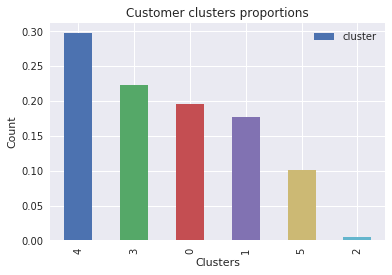

In [14]:
# Plot the data clusters
cust_proportions.plot(kind = "bar", legend = True)
plt.title('Customer clusters proportions')
plt.xlabel('Clusters')
plt.ylabel('Count');

In [9]:
customers_clean.groupby('cluster').mean()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.108187,1.392789,9.462122,8.848884,1.765600,0.015706,0.027705,1.986077,1.674732,0.012621,...,2.270651,5.262614,5.014517,3.115771,5.040835,8.857402,4.230099,2.278122,1.280754,3.699324
1,1.163964,1.784969,9.795211,9.596444,15.394026,0.175723,0.030441,1.727501,14.372973,0.017212,...,2.786202,5.647131,5.552489,3.705500,5.178900,8.547131,3.190138,3.315884,1.488952,3.538170
2,0.836891,1.290138,15.613951,11.413673,1.491995,0.018115,0.227300,3.525331,1.419573,0.016799,...,2.109779,2.072610,2.735305,2.184080,2.927992,8.916867,4.604968,1.839146,1.245114,3.520445
3,1.172831,1.425341,10.660688,9.445980,2.590191,0.075474,0.065176,2.411396,2.420535,0.048485,...,2.682442,3.883893,3.659101,2.390457,4.561143,8.835236,2.477130,1.970351,1.246975,3.588261
4,-0.839100,2.301469,15.277902,15.506265,4.189611,0.032943,0.518048,2.487926,3.803917,0.011866,...,2.362791,3.565513,4.989544,4.184217,2.689486,8.121567,3.649822,2.936271,1.442868,2.689569
5,0.892794,3.231986,8.050967,7.876977,26.680141,0.274165,0.052724,1.576450,28.349736,0.010545,...,2.973638,6.427065,6.300527,4.300527,5.393673,7.202109,3.826011,3.432337,1.543058,3.513181


In [15]:
labels_true = customers_km.labels_

In [16]:
labels_true

array([4, 1, 5, ..., 4, 1, 3], dtype=int32)

In [35]:
silhouette_score(scaled_features, labels_true, metric = 'euclidean',sample_size=10000)

0.029673519952437385

### Population data set

In [10]:
azdias_clean = pd.read_csv('azdias_clean.csv')

In [11]:
scaler1 = StandardScaler()

In [12]:
# Preprocessing using standard scaler
features = scaler1.fit_transform(azdias_clean)

In [13]:
# instantitate kmeans
population_km = KMeans(n_clusters=6)

In [14]:
# fit alogorith to features
pop_pred =  population_km.fit_predict(features)

In [15]:
pop_pred

array([2, 4, 0, ..., 5, 5, 5], dtype=int32)

In [16]:
azdias_clean['cluster'] = pop_pred

In [24]:
# Calculate Proportion of features which belong to different clusters
pop_proportions = azdias_clean['cluster'].value_counts()/azdias_clean.shape[0]

In [25]:
pop_proportions

1    0.230427
4    0.229095
3    0.212867
0    0.166319
5    0.151989
2    0.009303
Name: cluster, dtype: float64

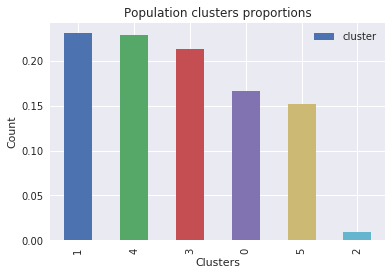

In [26]:
# Plot the data clusters
pop_proportions.plot(kind = "bar", legend = True)
plt.title('Population clusters proportions')
plt.xlabel('Clusters')
plt.ylabel('Count');

In [17]:
azdias_clean.groupby('cluster').mean()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.350488,2.726118,11.339954,11.499888,2.403543,0.006077,0.074527,1.802545,2.238955,0.002510,...,2.187810,5.889797,7.028756,5.105174,4.452385,8.375536,5.059591,2.980448,1.461374,3.302161
1,0.006679,4.411101,12.262091,12.773376,20.680332,0.119070,0.083141,1.476739,20.338323,0.006218,...,2.708199,6.411101,7.750115,5.991018,4.708890,7.215569,4.213726,3.977660,1.533164,2.936435
2,0.290430,2.763017,12.113875,12.260884,4.871880,0.056163,0.127613,1.952001,4.455020,0.013555,...,2.578269,4.992033,6.034697,4.536788,4.210323,8.153175,2.861014,2.839787,1.495362,3.110328
3,0.879544,2.699563,10.244120,10.392824,14.232251,0.063688,0.025233,1.590706,13.040685,0.003956,...,2.572007,6.355194,7.226207,5.176605,5.037218,8.303568,3.520226,3.555318,1.538230,3.473562
4,-0.509279,2.594532,16.175037,15.673656,2.359888,0.006865,0.427411,2.913407,2.197697,0.003284,...,2.132722,2.741905,4.200897,3.821382,2.558710,8.178181,4.648307,2.672084,1.531260,2.592811
5,-0.946855,4.810790,15.874212,17.509819,13.385087,0.046930,0.240937,1.607099,11.884429,0.001207,...,2.576017,5.306501,7.494414,6.656504,3.801378,6.805541,3.598059,4.480919,1.539213,2.047494


In [27]:
labels_pred = population_km.labels_

In [28]:
labels_pred

array([5, 1, 4, ..., 3, 3, 3], dtype=int32)

In [36]:
silhouette_score(features, labels_pred, metric = 'euclidean',sample_size=10000)

0.033850648093684439

### Customer Segmentation Summary

More than 89% of features belong to clusters 3, 0 and 4 for the customer data set
More than 84% of feature belong to clusters 4, 0, 2, and 1 for the population data set.
The marketing campaign should target customerss in segments 4 and 0 for maximum impact.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [13]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
clean_data(mailout_train)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
3,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,0.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1,1.0,8.0,8.0,2.0,0.0,0.0,1.0,1.0,0.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,2,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
11,2,1.0,8.0,8.0,2.0,0.0,0.0,2.0,2.0,0.0,...,7.0,8.0,5.0,6.0,9.0,7.0,3,0,1,4
12,1,1.0,15.0,8.0,1.0,0.0,0.0,3.0,1.0,0.0,...,1.0,1.0,1.0,3.0,9.0,4.0,3,0,2,4
13,1,1.0,20.0,12.0,1.0,0.0,0.0,3.0,1.0,0.0,...,7.0,4.0,2.0,2.0,9.0,1.0,3,0,2,3


In [17]:
# Save clean dataframe
mailout_train.to_csv('mailout_train_clean.csv', index=False)

In [2]:
mailout_train_clean = pd.read_csv('mailout_train_clean.csv')

In [3]:
# Define features and varibale
y = mailout_train_clean.RESPONSE
X = mailout_train_clean.drop('RESPONSE', axis=1)

In [4]:
# split data into train and tesr
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

In [5]:
# train classifier
clf = LogisticRegression().fit(X_train, y_train)

# predict on test data
predictions = clf.predict(X_test)

In [6]:
# display test results
print(classification_report(y_test, predictions))


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8703
          1       0.00      0.00      0.00       111

avg / total       0.97      0.99      0.98      8814



In [7]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[8702,    1],
       [ 111,    0]])

In [8]:
# display test results
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.987292943045


In [9]:
# generate a no response predictionnr
nr_probs = [0 for _ in range(len(y_test))]

In [10]:
# predict probabilities
lr_probs = clf.predict_proba(X_test)

In [11]:
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

In [12]:
# calculate scores
nr_auc = roc_auc_score(y_test, nr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [13]:
# calculate roc curves
nr_fpr, nr_tpr, _ = roc_curve(y_test, nr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

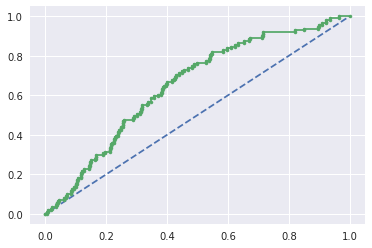

In [14]:
# plot the roc curve for the model
pyplot.plot(nr_fpr, nr_tpr, linestyle='--', label='No Response')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic');

In [5]:
#Grid Search
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'roc_auc')
grid_clf_acc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [6]:
print("tuned hpyerparameters :(best parameters) ",grid_clf_acc.best_params_)


tuned hpyerparameters :(best parameters)  {'C': 0.09, 'penalty': 'l1'}


In [8]:
# train classifier
clf = LogisticRegression(C=0.09,penalty="l1").fit(X_train, y_train)

# predict on test data
predictions = clf.predict(X_test)

In [9]:
# display test results
print(classification_report(y_test, predictions))


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8714
          1       0.00      0.00      0.00       100

avg / total       0.98      0.99      0.98      8814



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[8714,    0],
       [ 100,    0]])

In [15]:
# display test results
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.988654413433


In [16]:
# generate a no response predictionnr
nr_probs = [0 for _ in range(len(y_test))]

In [17]:
# predict probabilities
lr_probs = clf.predict_proba(X_test)

In [18]:
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

In [19]:
# calculate scores
nr_auc = roc_auc_score(y_test, nr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [20]:
# calculate roc curves
nr_fpr, nr_tpr, _ = roc_curve(y_test, nr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

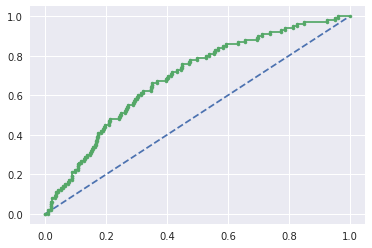

In [21]:
# plot the roc curve for the model
pyplot.plot(nr_fpr, nr_tpr, linestyle='--', label='No Response')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic');

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [28]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
# Fix mixed data types
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].replace(['X'],'-1')

In [30]:
# Change datat type
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].astype(float)

In [31]:
# Fix mixed data types
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].replace(['XX'],'-1')

In [32]:
# Change datat type
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].astype(float)

In [33]:
# drop columns with more thna 50% nan
mailout_test.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','KK_KUNDENTYP','EXTSEL992'], axis=1, inplace=True)

In [34]:
# drop columns not needed for features
mailout_test.drop(['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ'], axis=1, inplace=True)

In [35]:
# Impute missing values with means
mailout_test.fillna(mailout_test.mean(), inplace=True)

In [36]:
# Save cleaned data set
mailout_test.to_csv('mailout_test_clean.csv', index=False)

In [22]:
mailout_test_clean = pd.read_csv('mailout_test_clean.csv')

In [23]:
# define feature
X1 = mailout_test_clean.drop('LNR', axis=1)

In [24]:
# Predict
RESPONSE = clf.predict_proba(X1)[:,1]

In [25]:
RESPONSE

array([ 0.05959424,  0.02813543,  0.00220903, ...,  0.00758109,
        0.01672315,  0.00384158])

In [26]:
# Create new columns
mailout_test_clean['RESPONSE'] = RESPONSE

In [27]:
# format dataframe for kaggle submission
mailout = mailout_test_clean[['LNR', 'RESPONSE']].copy()

In [28]:
# Save File
mailout.to_csv('mailout.csv', index=False)